HW2 - Detecting Type 1 Diabetes


We will begin by answering the theoretical questions at the beginning of the assignment.

Q1: Accuracy is defined as TP+TN/TP+TN+FN+FP. This representation is not very accurate because lets say for example we have 100 patients and 90 do not have the disease, therefore, a model which will predict that everyone has the disease will be 90 percent accurate. This is of course a terrible model. Performance refers to several parameters such as specificity, sensitivity, F1 score and more. These parameters are much more effective because they display an accurate representation of our model. Specificity will allow us to know the percentage of false negatives, Sensitivity false positives, and the F1 score is a mix of the two which gives a more realistic evaluation metric of the model. Our previous example will have a very low F1 score (which is the correct evaluation).

Q2: Using multiple features for your model is good because it has a lot of information. However, if there are features which are not really correlated with the disease or features which are redundant, this will hurt the model. In the example given, income (I) is completely irrelevant and will not tell us anything about the disease. Therefore I would use the two-feature model because it is more relevant and will be faster as it requires less computational power.

Q3: If the different groups are not seperable to the human eye I would use a nonlinear SVM. This is because perhaps in a different domain the different groups will be seperable and the model will be more successful.

Q4: The differences between linear regression and linear svm are as follows. Linear regression only has one hyperparameter lamda. This parameter is the regularization parameter. Linear SVM on the other hand has 2 hyperparameters, C which gives a punishment for misclassifications and gamma which determines how far the model reaches the training data (high gamma=close, low gamma=far). Another difference between linear regression and linear svm is the outputs. Linear regression's output is a discrete variable in which there is the probability that each observation will belong to a certain group. Linear SVM's output is a plane or a line which seperates between two groups.

Let's begin. First we will import relevant packages and load our data.

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import random
file = Path.cwd().joinpath('HW2_data.csv')
Data=pd.read_csv(file)
print('hello')

hello


We will replace the empyty cells with values that are according to the distribution of that particular column. This way we dont disrupt the data and we dont lose any data.

In [2]:
# X=fill_empties(Data)
nullContainingFeatures = Data.columns[Data.isnull().any()]
numYesAnswers = Data[nullContainingFeatures].__eq__('Yes').sum()
numNoAnswers = Data[nullContainingFeatures].__eq__('No').sum()
sumAnswers = numYesAnswers+numNoAnswers
X = Data
for n in nullContainingFeatures:
    X[n] = X[n].fillna(np.random.choice(["Yes", "No"],p=[numYesAnswers[n]/sumAnswers[n],numNoAnswers[n]/sumAnswers[n]]))

In [3]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
y = X['Diagnosis']
X.drop(columns='Diagnosis', inplace=True)
#we will change the 1s and 0s in Family history to be yes and no like the rest of the features
X['Family History']=X['Family History'].replace({1:'Yes'})
X['Family History']=X['Family History'].replace({0:'No'})
#X = np.concatenate((np.ones((len(y), 1)), X), axis=1) # add bias term
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Now we will do some data exploration. We will begin by showing that our positive data is divided equally between the train and the test set.

                         Test%     Train%    Delta%
Increased Urination  48.672566  48.230088  0.442478
Increased Thirst     38.053097  44.026549 -5.973451
Sudden Weight Loss   45.132743  39.159292  5.973451
Weakness             60.176991  56.415929  3.761062
Increased Hunger     41.592920  44.026549 -2.433628
Genital Thrush       29.203540  22.787611  6.415929
Visual Blurring      41.592920  45.796460 -4.203540
Itching              46.017699  50.221239 -4.203540
Irritability         25.663717  23.008850  2.654867
Delayed Healing      43.362832  46.902655 -3.539823
Partial Paresis      42.477876  42.699115 -0.221239
Muscle Stiffness     36.283186  35.619469  0.663717
Hair Loss            41.592920  34.292035  7.300885
Obesity              14.159292  17.477876 -3.318584
Family History       52.212389  50.221239  1.991150


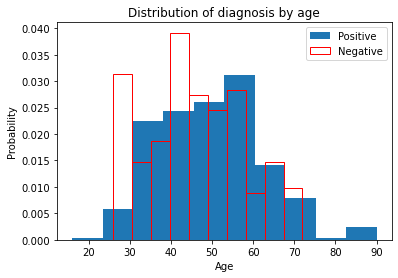

In [4]:
percent_positive_test=pd.DataFrame()
percent_positive_train=pd.DataFrame()

#first we will remove the features which are not binary
X_train_new=X_train.drop('Age',axis=1)
X_train_new=X_train_new.drop('Gender',axis=1)
X_test_new=x_test.drop('Age',axis=1)
X_test_new=X_test_new.drop('Gender',axis=1)

#now we will find the percentage of positive values for each feature for the train and test set
for column in X_train_new:
    X_train_positive=(X_train_new[column]=='Yes')
    percent_positive_train[column]=X_train_positive.value_counts(normalize=True)

for column in X_test_new:
    X_test_positive=(X_test_new[column]=='Yes')
    percent_positive_test[column]=X_test_positive.value_counts(normalize=True)

data_tag_test=percent_positive_test.drop([0,0])
data_tag_test=data_tag_test.transpose()
data_tag_train=percent_positive_train.drop([0,0])
data_tag_train=data_tag_train.transpose()
data_tag_train['Test%']=data_tag_test*100
data_tag_train['Train%']=percent_positive_train.drop([0,0]).transpose()*100

data_tag_train['Delta%']=(data_tag_train['Test%']-data_tag_train['Train%'])
print(data_tag_train[['Test%','Train%','Delta%']])

# justify dropping age feature
agePositive = X["Age"][y=='Positive']
ageNegative = X["Age"][y=='Negative']

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(agePositive,density=True)
ax.hist(ageNegative,density=True,ec='red',fc='none')
ax.set_xlabel('Age')
ax.set_ylabel('Probability')
ax.set_title('Distribution of diagnosis by age')
ax.legend(("Positive", "Negative"))
plt.show()


As we can see from the bar graph above, the age is not correlated with the disease, the distribution of positive and negative outcomes across different ages is very similar therefore we will remove this feature when creating our models.

In [5]:
def plot_features(X,y,feature):
    import matplotlib.pyplot as plt
    y=np.array(y)
    temp=pd.DataFrame(X[feature])
    idx_positive=np.where(y=='Positive')
    idx_negative=np.where(y=='Negative')
    first_y=temp.loc[idx_positive].value_counts().sort_index(ascending=False)
    second_y=temp.loc[idx_negative].value_counts().sort_index(ascending=False)
    labels=['Positive', 'Negative']

    x = np.arange(2)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x + 0.00, first_y, color = 'b', width = 0.25)
    ax.bar(x + 0.25, second_y, color = 'g', width = 0.25)
    ax.set_ylabel("counts")
    ax.set_xticks(x+0.125)
    if feature=='Gender':
        ax.set_xticklabels(['Male','Female'])
    else:
        ax.set_xticklabels(['Yes','No'])
    
    ax.set_title('Positive/Negative of {:}'.format(feature))
    ax.legend(labels)
    plt.show()

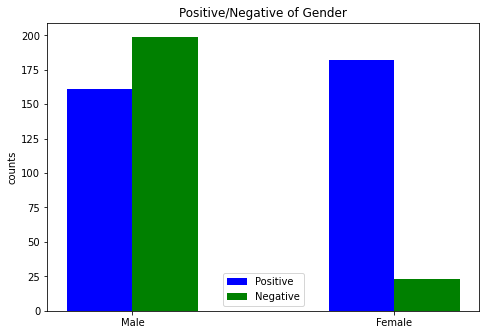

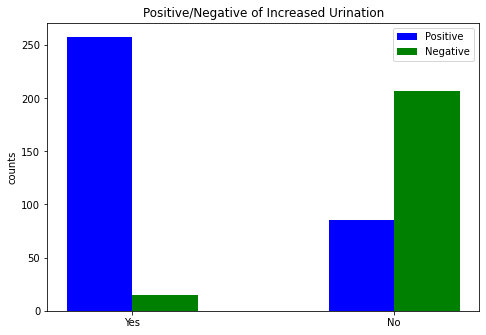

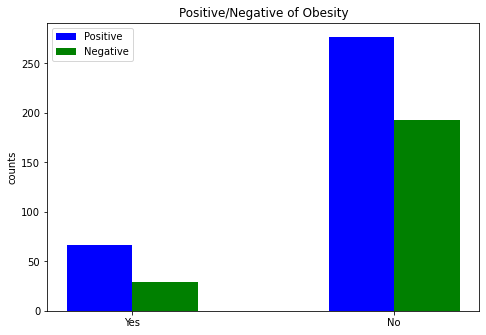

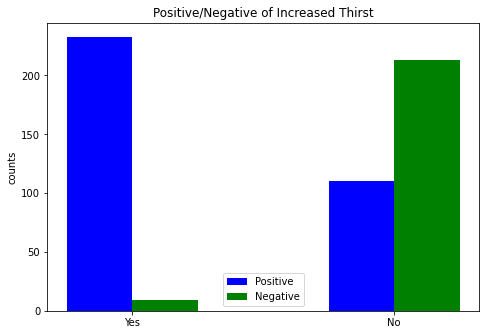

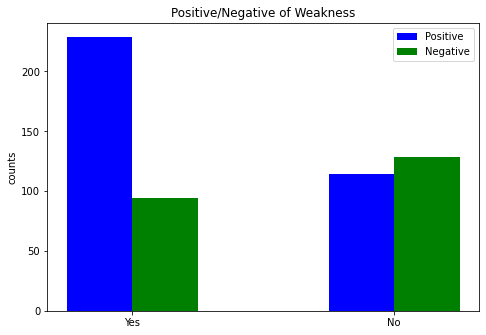

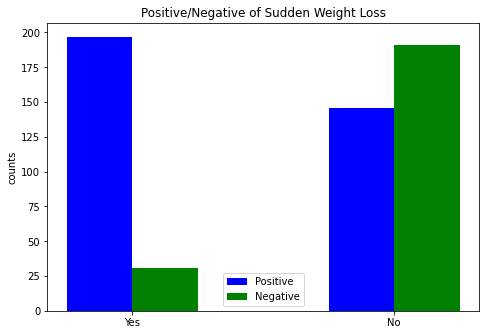

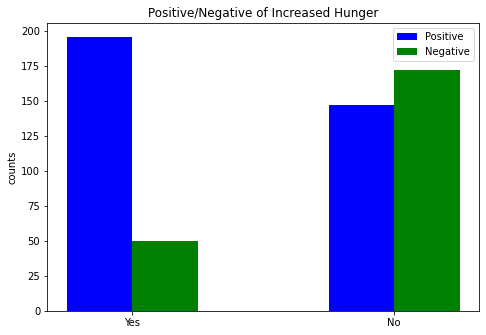

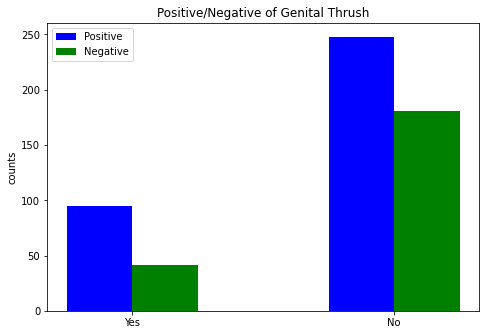

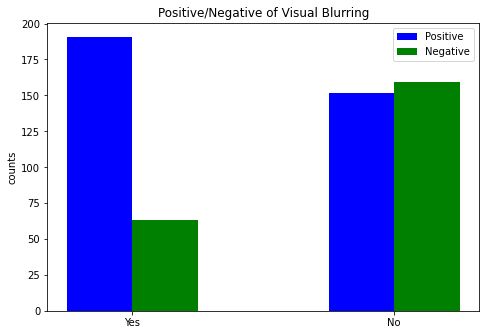

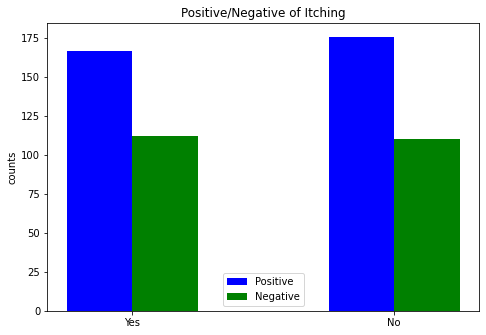

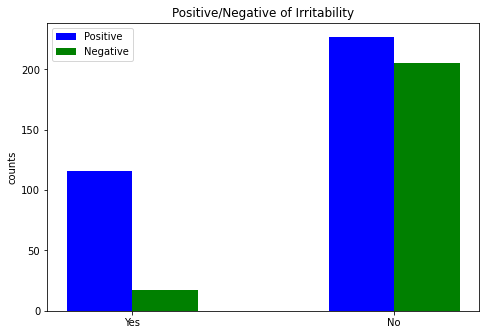

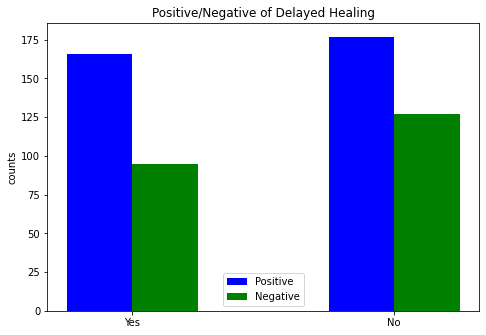

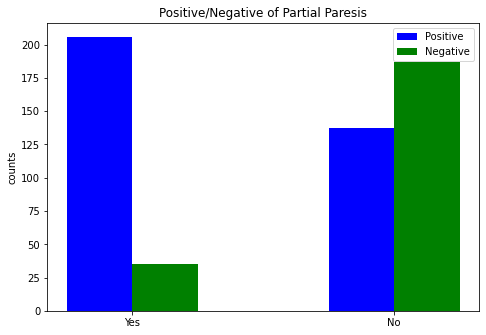

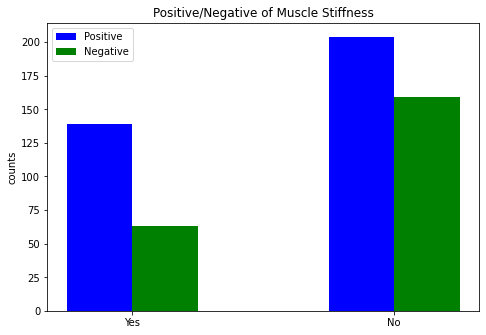

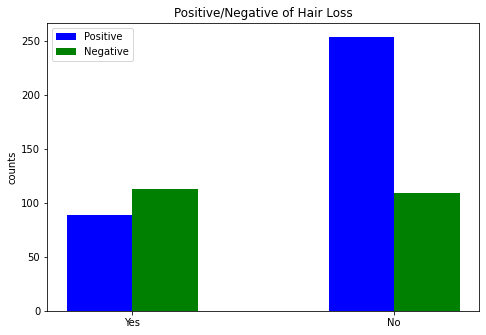

In [6]:
plot_features(X,y,'Gender')
plot_features(X,y,'Increased Urination')
plot_features(X,y,'Obesity')
plot_features(X,y,'Increased Thirst')
plot_features(X,y,'Weakness')
plot_features(X,y,'Sudden Weight Loss')
plot_features(X,y,'Increased Hunger')
plot_features(X,y,'Genital Thrush')
plot_features(X,y,'Visual Blurring')
plot_features(X,y,'Itching')
plot_features(X,y,'Irritability')
plot_features(X,y,'Delayed Healing')
plot_features(X,y,'Partial Paresis')
plot_features(X,y,'Muscle Stiffness')
plot_features(X,y,'Hair Loss')

If we examine the above graphs we see that Increased Thirst and Increased Urination are important features. In these features if the answer is yes, the probability that the person has the disease is very high and also if he doesnt have these features (the answer is no) the probability is higher that he is healthy. Other important features could be Sudden Weight Loss and Partial Paresis. 
An unexpected finding is that most females have the disease. This is probably just an unbalanced sample of people, rather than a characteristic of the disease

Now we will continue and encode our data as one hot vectors

In [7]:
def encoding_data(X):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    if X.size > len(X):
        X_encoded=X.drop('Age',axis=1)
        for column in X_encoded:
            integer_encoded = label_encoder.fit_transform(X_encoded[column])
            integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
            onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
            X_encoded[column]=onehot_encoded

        final=X_encoded

    else:
        X_encoded = pd.DataFrame(X)
        X_encoded = X_encoded.replace({'Positive':1})
        X_encoded = X_encoded.replace({'Negative':0})
        final=X_encoded
        
    return final


In [8]:
encoded_X_train=encoding_data(X_train)
encoded_X_test=encoding_data(x_test)
encoded_y_train=encoding_data(Y_train)
encoded_y_test=encoding_data(y_test)

#We will print encoded_y_train just to see that indeed there are only ones and zeros:
print(encoded_y_train)

     Diagnosis
6            0
404          0
359          0
322          1
97           1
..         ...
271          0
147          1
24           0
269          0
547          0

[452 rows x 1 columns]


In [9]:
#We will define vectors which are the test and train vectors of X with the two most important features. We will use this later in section 7
X_train_2feat=encoded_X_train[['Increased Thirst','Increased Urination']]
X_test_2feat=encoded_X_test[['Increased Thirst','Increased Urination']]

Now we will run our linear machine learning model with 5k folds

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
max_iter=2000
n_splits=5
solver = 'liblinear'
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)
log_reg = LogisticRegression(random_state=5, max_iter=max_iter,solver=solver)
lmbda = np.array([0.01, 0.01, 1, 10, 100, 1000])
pipe = Pipeline(steps=[('scale', StandardScaler()), ('logistic', log_reg)])
clf = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': ['l1','l2']},
                   scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                   refit='roc_auc', verbose=3, return_train_score=True)
clf.fit(encoded_X_train, np.ravel(encoded_y_train))
clf.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.945, test=0.901), f1=(train=0.954, test=0.917), precision=(train=0.963, test=0.926), recall=(train=0.945, test=0.909), roc_auc=(train=0.988, test=0.962), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.936, test=0.923), f1=(train=0.947, test=0.935), precision=(train=0.958, test=0.962), recall=(train=0.936, test=0.909), roc_auc=(train=0.983, test=0.976), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.953, test=0.911), f1=(train=0.961, test=0.925), precision=(train=0.977, test=0.942), recall=(train=0.945, test=0.907), roc_auc=(train=0.980, test=0.975), total=   0.0s
[CV] logistic__C=100.0, log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.936, test=0.923), f1=(train=0.947, test=0.935), precision=(train=0.958, test=0.962), recall=(train=0.936, test=0.909), roc_auc=(train=0.983, test=0.976), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.953, test=0.911), f1=(train=0.961, test=0.925), precision=(train=0.977, test=0.942), recall=(train=0.945, test=0.907), roc_auc=(train=0.980, test=0.975), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.931, test=0.933), f1=(train=0.943, test=0.946), precision=(train=0.949, test=0.930), recall=(train=0.936, test=0.964), roc_auc=(train=0.981, test=0.973), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.931, test=0.922), f1=(t

C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_cl

[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.853, test=0.868), f1=(train=0.868, test=0.880), precision=(train=0.956, test=0.978), recall=(train=0.795, test=0.800), roc_auc=(train=0.956, test=0.972), total=   0.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.854, test=0.811), f1=(train=0.868, test=0.817), precision=(train=0.956, test=0.974), recall=(train=0.795, test=0.704), roc_auc=(train=0.959, test=0.932), total=   0.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.856, test=0.900), f1=(train=0.867, test=0.913), precision=(train=0.983, test=0.979), recall=(train=0.776, test=0.855), roc_auc=(train=0.959, test=0.962), total=   0.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.862, test=0.878), f1=(t

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.6s finished


{'logistic__C': 1.0, 'logistic__penalty': 'l1'}

In [11]:
def calc_evalmetrics(encoded_X_test,encoded_X_train, encoded_y_test, encoded_y_train,clf):

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import log_loss
    from sklearn.metrics import plot_confusion_matrix, roc_auc_score,plot_roc_curve

    calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
    calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
    calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
    calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

    chosen_clf = clf.best_estimator_
    y_pred_test = chosen_clf.predict(encoded_X_test) 
    y_pred_train = chosen_clf.predict(encoded_X_train) 

    y_pred_proba_test = chosen_clf.predict_proba(encoded_X_test)
    y_pred_proba_train = chosen_clf.predict_proba(encoded_X_train)

    TN = calc_TN(encoded_y_test, y_pred_test)
    FP = calc_FP(encoded_y_test, y_pred_test)
    FN = calc_FN(encoded_y_test, y_pred_test)
    TP = calc_TP(encoded_y_test, y_pred_test)
    TN_train = calc_TN(encoded_y_train, y_pred_train)
    FP_train = calc_FP(encoded_y_train, y_pred_train)
    FN_train = calc_FN(encoded_y_train, y_pred_train)
    TP_train = calc_TP(encoded_y_train, y_pred_train)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    F1 = (2*Se*PPV)/(Se+PPV)
    Se_train = TP_train/(TP_train+FN_train)
    Sp_train = TN_train/(TN_train+FP_train)
    PPV_train = TP_train/(TP_train+FP_train)
    NPV_train = TN_train/(TN_train+FN_train)
    Acc_train = (TP_train+TN_train)/(TP_train+TN_train+FP_train+FN_train)
    F1_train = (2*Se_train*PPV_train)/(Se_train+PPV_train)
    print("Train loss is {:.2f}".format(log_loss(encoded_y_train,y_pred_proba_train)))
    print("Test loss is {:.2f}".format(log_loss(encoded_y_test,y_pred_proba_test)))
    print('Test Sensitivity is {:.2f} \nTest Specificity is {:.2f} \nTest PPV is {:.2f} \nTest NPV is {:.2f} \nTest Accuracy is {:.2f} \nTest F1 is {:.2f} '.format(Se,Sp,PPV,NPV,Acc,F1))
    print('Test AUROC is {:.2f}'.format(roc_auc_score(encoded_y_test, y_pred_proba_test[:,1])))
    print('Train Sensitivity is {:.2f} \nTrain Specificity is {:.2f} \nTrain PPV is {:.2f} \nTrain NPV is {:.2f} \nTrain Accuracy is {:.2f} \nTrain F1 is {:.2f} '.format(Se_train,Sp_train,PPV_train,NPV_train,Acc_train,F1_train))
    print('Train AUROC is {:.2f}'.format(roc_auc_score(encoded_y_train, y_pred_proba_train[:,1])))

In [12]:
calc_evalmetrics(encoded_X_test,encoded_X_train,encoded_y_test,encoded_y_train,clf)

Train loss is 0.17
Test loss is 0.23
Test Sensitivity is 0.94 
Test Specificity is 0.84 
Test PPV is 0.90 
Test NPV is 0.90 
Test Accuracy is 0.90 
Test F1 is 0.92 
Test AUROC is 0.97
Train Sensitivity is 0.94 
Train Specificity is 0.93 
Train PPV is 0.95 
Train NPV is 0.91 
Train Accuracy is 0.93 
Train F1 is 0.94 
Train AUROC is 0.98


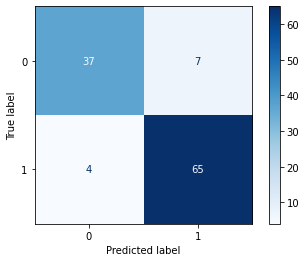

In [13]:
scaler=StandardScaler()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix, roc_auc_score,plot_roc_curve
import matplotlib.pyplot as plt
x_tr = scaler.fit_transform(encoded_X_train)
x_tst = scaler.transform(encoded_X_test)
log_reg.fit(x_tr, np.ravel(encoded_y_train))
y_pred_test = log_reg.predict(x_tst)
y_pred_proba_test = log_reg.predict_proba(x_tst)
plot_confusion_matrix(log_reg, x_tst, encoded_y_test, cmap=plt.cm.Blues)
plt.grid(False)

Now we will train our data using a nonlinear classifier SVM

In [14]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)
from sklearn.svm import SVC
svc = SVC(probability=True)
C = np.array([0.1, 1, 100, 1000])#, 10, 100, 1000])

pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm_nonlin = GridSearchCV(estimator=pipe,
             param_grid={'svm__kernel':['rbf', 'poly'], 'svm__degree':[3],'svm__gamma':['auto','scale'],'svm__C':C},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
svm_nonlin.fit(encoded_X_train, np.ravel(encoded_y_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.928, test=0.912), f1=(train=0.942, test=0.930), precision=(train=0.914, test=0.898), recall=(train=0.973, test=0.964), roc_auc=(train=0.987, test=0.977), total=   0.1s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.925, test=0.945), f1=(train=0.940, test=0.956), precision=(train=0.917, test=0.931), recall=(train=0.963, test=0.982), roc_auc=(train=0.986, test=0.993), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.945, test=0.922), f1=(train=0.955, test=0.935), precision=(train=0.942, test=0.943), recall=(train=0.968, test=0.926), roc_auc=(train=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.942, test=0.900), f1=(train=0.953, test=0.922), precision=(train=0.934, test=0.883), recall=(train=0.973, test=0.964), roc_auc=(train=0.988, test=0.976), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.936, test=0.900), f1=(train=0.949, test=0.922), precision=(train=0.930, test=0.883), recall=(train=0.968, test=0.964), roc_auc=(train=0.986, test=0.986), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly ....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.947, test=0.945), f1=(train=0.957, test=0.953), precision=(train=0.959, test=0.981), recall=(train=0.954, test=0.927), roc_auc=(train=0.992, test=0.988), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly ....
[CV]  svm__C=0.1, svm__degr

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-01, 1.e+00, 1.e+02, 1.e+03]),
                         'svm__degree': [3], 'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [15]:
calc_evalmetrics(encoded_X_test,encoded_X_train,encoded_y_test,encoded_y_train,svm_nonlin)

Train loss is 0.03
Test loss is 0.17
Test Sensitivity is 0.97 
Test Specificity is 0.91 
Test PPV is 0.94 
Test NPV is 0.95 
Test Accuracy is 0.95 
Test F1 is 0.96 
Test AUROC is 0.98
Train Sensitivity is 1.00 
Train Specificity is 0.99 
Train PPV is 0.99 
Train NPV is 1.00 
Train Accuracy is 1.00 
Train F1 is 1.00 
Train AUROC is 1.00


As we can see from the parameters above, we recieved higher numbers in all parameters for the non-linear model therefore we can conclude that the nonlinear model is a better fit.

Now we will train a random forest classifier on our data:

In [16]:
def norm_standard(CTG_features, mode='none'):
    """

    :param CTG_features: Pandas series of CTG features
    :param selected_feat: A two elements tuple of strings of the features for comparison
    :param mode: A string determining the mode according to the notebook
    :param flag: A boolean determining whether or not plot a histogram
    :return: Dataframe of the normalized/standardazied features called nsd_res
    """
    nsd_res = {} #CTG_features
    if mode=='none':
        nsd_res=CTG_features
        
    if mode == 'standard':
        mean = ()
        std = ()
        for column in CTG_features:
            mean = CTG_features.loc[:,column].mean()
            std = CTG_features.loc[:,column].std()
            nsd_res[column] = (CTG_features.loc[:,column] - mean) / std
    if mode == 'mean':
        mean = ()
        xmax = ()
        xmin = ()
        for column in CTG_features:
            mean = CTG_features.loc[:,column].mean()
            xmax = CTG_features.loc[:,column].max()
            xmin = CTG_features.loc[:,column].min()
            nsd_res[column] = (CTG_features.loc[:,column] - mean) / (xmax - xmin)
    if mode == 'MinMax':
        xmin = ()
        xmax = ()
        for column in CTG_features:
            xmax = CTG_features.loc[:,column].max()
            xmin = CTG_features.loc[:,column].min()
            nsd_res[column] = (CTG_features.loc[:,column] - xmin) / (xmax - xmin)

    return pd.DataFrame(nsd_res)

In [17]:
from sklearn.ensemble import RandomForestClassifier as rfc
mode =  'standard'
clf_RF = rfc(n_estimators=10)
clf_RF.fit(norm_standard(encoded_X_train, mode=mode), np.ravel(encoded_y_train))
y_pred = clf_RF.predict(norm_standard(encoded_X_test, mode=mode))
feature_importances = pd.DataFrame(clf_RF.feature_importances_, index=encoded_X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                     importance
Increased Urination    0.292132
Increased Thirst       0.132466
Gender                 0.115388
Partial Paresis        0.085197
Itching                0.058230
Hair Loss              0.049616
Delayed Healing        0.042559
Sudden Weight Loss     0.040165
Irritability           0.034834
Increased Hunger       0.031455
Genital Thrush         0.026949
Visual Blurring        0.022650
Weakness               0.021947
Obesity                0.020936
Muscle Stiffness       0.015647
Family History         0.009830


As we can see, increased thirst and increased urination are the most important features according to the random forest classifier. If we look back at the graphs we displayed for each feature, these features are indeed very correlated with the disease. Meaning, if the answer is yes for these features, very high probability that this person has the disease.

Now we will use pca to perform dimensionality reduction on our data

In [18]:
def plt_2d_pca(X_pca,y):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='b')
    ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='r')
    ax.legend(('Positive','Negative'))
    ax.plot([0], [0], "ko")
    ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.set_xlabel('$U_1$')
    ax.set_ylabel('$U_2$')
    ax.set_title('2D PCA')

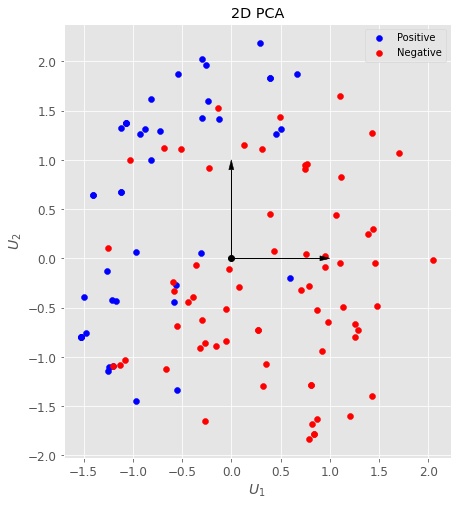

In [19]:
import itertools
from tqdm import tqdm
import sys
import matplotlib as mpl
import seaborn as sns
mpl.style.use(['ggplot']) 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from IPython.display import display, clear_output
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

n_components=2
pca = PCA(n_components=n_components, whiten=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(encoded_X_train)
X_test = scaler.transform(encoded_X_test)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt_2d_pca(X_test_pca,np.ravel(encoded_y_test))

The data is sort of seperable using just two features but there would be a lot of mistakes, I would not recommend using just two features as the false positives would be very large (you can see from the graph that you can run a diagonal between the blue and the red but there will be a lot of reds on the blue side).

Now we will train our linear and nonlinear model using the dimensionality reduced data:

In [20]:
#linear with dimensionality reduced:
clf.fit(X_train_pca, np.ravel(encoded_y_train))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.856, test=0.813), f1=(train=0.880, test=0.844), precision=(train=0.892, test=0.852), recall=(train=0.868, test=0.836), roc_auc=(train=0.943, test=0.916), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.853, test=0.868), f1=(train=0.876, test=0.891), precision=(train=0.895, test=0.891), recall=(train=0.858, test=0.891), roc_auc=(train=0.930, test=0.970), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.873, test=0.789), f1=(train=0.894, test=0.816), precision=(train=0.907, test=0.857), recall=(train=0.882, test=0.778), roc_auc=(train=0.948, test=0.894), total=   0.0s
[CV] logistic__C=100.0, log

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.853, test=0.868), f1=(train=0.876, test=0.891), precision=(train=0.895, test=0.891), recall=(train=0.858, test=0.891), roc_auc=(train=0.930, test=0.970), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.873, test=0.789), f1=(train=0.894, test=0.816), precision=(train=0.907, test=0.857), recall=(train=0.882, test=0.778), roc_auc=(train=0.948, test=0.894), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.845, test=0.900), f1=(train=0.870, test=0.916), precision=(train=0.883, test=0.942), recall=(train=0.858, test=0.891), roc_auc=(train=0.937, test=0.941), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.823, test=0.867), f1=(t

C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_cl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=5,
                                                           solver='liblinear'))]),
             param_grid={'logistic__C': array([1.e+02, 1.e+02, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
                         'logistic__penalty': ['l1', 'l2']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [21]:
calc_evalmetrics(X_test_pca,X_train_pca,encoded_y_test,encoded_y_train,clf)

Train loss is 0.64
Test loss is 0.64
Test Sensitivity is 0.83 
Test Specificity is 0.84 
Test PPV is 0.89 
Test NPV is 0.76 
Test Accuracy is 0.83 
Test F1 is 0.86 
Test AUROC is 0.92
Train Sensitivity is 0.85 
Train Specificity is 0.94 
Train PPV is 0.95 
Train NPV is 0.80 
Train Accuracy is 0.88 
Train F1 is 0.90 
Train AUROC is 0.94


In [22]:
#nonlinear with dimensionality reduced
svm_nonlin.fit(X_train_pca,np.ravel(encoded_y_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.875, test=0.901), f1=(train=0.895, test=0.913), precision=(train=0.918, test=0.979), recall=(train=0.872, test=0.855), roc_auc=(train=0.955, test=0.967), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.898, test=0.923), f1=(train=0.913, test=0.936), precision=(train=0.938, test=0.944), recall=(train=0.890, test=0.927), roc_auc=(train=0.951, test=0.977), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.909, test=0.767), f1=(train=0.922, test=0.796), precision=(train=0.961, test=0.837), recall=(train=0.886, test=0.759), roc_auc=(train=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly ....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.889, test=0.901), f1=(train=0.912, test=0.922), precision=(train=0.881, test=0.883), recall=(train=0.945, test=0.964), roc_auc=(train=0.964, test=0.979), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly ....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.901, test=0.856), f1=(train=0.921, test=0.883), precision=(train=0.893, test=0.860), recall=(train=0.950, test=0.907), roc_auc=(train=0.975, test=0.927), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly ....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.890, test=0.878), f1=(train=0.913, test=0.904), precision=(train=0.874, test=0.867), recall=(train=0.954, test=0.945), roc_auc=(train=0.969, test=0.963), total=   0.0s
[CV] svm__C=0.1, svm__de

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    5.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-01, 1.e+00, 1.e+02, 1.e+03]),
                         'svm__degree': [3], 'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [23]:
calc_evalmetrics(X_test_pca,X_train_pca,encoded_y_test,encoded_y_train,svm_nonlin)

Train loss is 0.24
Test loss is 0.32
Test Sensitivity is 0.88 
Test Specificity is 0.80 
Test PPV is 0.87 
Test NPV is 0.81 
Test Accuracy is 0.85 
Test F1 is 0.88 
Test AUROC is 0.94
Train Sensitivity is 0.94 
Train Specificity is 0.83 
Train PPV is 0.90 
Train NPV is 0.90 
Train Accuracy is 0.90 
Train F1 is 0.92 
Train AUROC is 0.97


In [24]:
#linear with 2 best features:
clf.fit(X_train_2feat, np.ravel(encoded_y_train))
calc_evalmetrics(X_test_2feat,X_train_2feat,encoded_y_test,encoded_y_train,clf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.875, test=0.868), f1=(train=0.894, test=0.885), precision=(train=0.926, test=0.939), recall=(train=0.863, test=0.836), roc_auc=(train=0.912, test=0.892), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.870, test=0.890), f1=(train=0.889, test=0.902), precision=(train=0.917, test=0.979), recall=(train=0.863, test=0.836), roc_auc=(train=0.908, test=0.912), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.878, test=0.856), f1=(train=0.897, test=0.871), precision=(train=0.927, test=0.936), recall=(train=0.868, test=0.815), roc_auc=(train=0.916, test=0.880), total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.865, test=0.911), f1=(train=0.883, test=0.926), precision=(train=0.925, test=0.943), recall=(train=0.845, test=0.909), roc_auc=(train=0.901, test=0.938), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l1 .........................
[CV]  logistic__C=100.0, logistic__penalty=l1, accuracy=(train=0.881, test=0.844), f1=(train=0.896, test=0.875), precision=(train=0.949, test=0.860), recall=(train=0.849, test=0.891), roc_auc=(train=0.911, test=0.900), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__C=100.0, logistic__penalty=l2, accuracy=(train=0.875, test=0.868), f1=(train=0.894, test=0.885), precision=(train=0.926, test=0.939), recall=(train=0.863, test=0.836), roc_auc=(train=0.912, test=0.892), total=   0.0s
[CV] logistic__C=100.0, logistic__penalty=l2 .........................
[CV]  logistic__

C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\bm-336546\lib\site-packages\sklearn\metrics\_cl

[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.870, test=0.890), f1=(train=0.889, test=0.902), precision=(train=0.917, test=0.979), recall=(train=0.863, test=0.836), roc_auc=(train=0.908, test=0.912), total=   0.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.878, test=0.856), f1=(train=0.897, test=0.871), precision=(train=0.927, test=0.936), recall=(train=0.868, test=0.815), roc_auc=(train=0.916, test=0.880), total=   0.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.865, test=0.911), f1=(train=0.883, test=0.926), precision=(train=0.925, test=0.943), recall=(train=0.845, test=0.909), roc_auc=(train=0.900, test=0.943), total=   0.0s
[CV] logistic__C=0.001, logistic__penalty=l2 .........................
[CV]  logistic__C=0.001, logistic__penalty=l2, accuracy=(train=0.881, test=0.844), f1=(t

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.5s finished


In [25]:
#nonlinear with 2 best features:
svm_nonlin.fit(X_train_2feat,np.ravel(encoded_y_train))
calc_evalmetrics(X_test_2feat,X_train_2feat,encoded_y_test,encoded_y_train,svm_nonlin)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.875, test=0.868), f1=(train=0.894, test=0.885), precision=(train=0.926, test=0.939), recall=(train=0.863, test=0.836), roc_auc=(train=0.877, test=0.852), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.870, test=0.890), f1=(train=0.889, test=0.902), precision=(train=0.917, test=0.979), recall=(train=0.863, test=0.836), roc_auc=(train=0.908, test=0.912), total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.878, test=0.856), f1=(train=0.897, test=0.871), precision=(train=0.927, test=0.936), recall=(train=0.868, test=0.815), roc_auc=(train=0.912, test=0.897), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.865, test=0.911), f1=(train=0.883, test=0.926), precision=(train=0.925, test=0.943), recall=(train=0.845, test=0.909), roc_auc=(train=0.900, test=0.943), total=   0.0s
[CV] svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf .....
[CV]  svm__C=0.1, svm__degree=3, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.881, test=0.844), f1=(train=0.896, test=0.875), precision=(train=0.949, test=0.860), recall=(train=0.849, test=0.891), roc_auc=(train=0.889, test=0.874), total=   0.0s
[CV] svm__C=0.1, svm__degre

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.6s finished


Which way is better?
The test Auroc for the dimensionality reduction is better than that of the best 2 features for both the linear and the nonlinear models. The sensitivity is the best in the nonlinear dimension reduced model. The specificity is better in the chosen best 2 features.
We think that in this case it is better to use dimensionality reduction - because as we saw earlier in the feature contribution analysis - the two best features combined could explain less than 40% of the total feature importance, therefore it is reasonable to assume that we will need to consider some more features aswell to better explain the prediction - which is what is achieved using PCA.